# Tulipa multi-year investment demonstration

- Adapted from Tulipa tutorial [multi-year investment](https://hackmd.io/CnhwFt1DQ_iT1LH_lQ7h0A)
> see in the `TulipaTUtorials/TulipaMultiYear.ipynb` for `TulipaTUtorials/Tulipa-multi-year-full`.

# Setup workflow environment

In [12]:
using Pkg; Pkg.activate(@__DIR__)

import TulipaIO as TIO
import TulipaEnergyModel as TEM
import TulipaClustering as TC
using DuckDB
using DataFrames
using Plots

# # For Win. system to fix the KaTex parse error in Jupyter Notebook
# Base.show(stdout, ::MIME"text/latex", df::DataFrame) = show(stdout, MIME("text/plain"), df)

  Activating project at `~/Projects/VintageDemo`


# Multi-year investment model cases

- Milestone years: 2030, 2040 and 2050.
- The system has 30GW initial wind capacity built in 2025, the model can choose to invest in wind in all three milestone years.
- unused tables: `flow-both.csv`, `flows-profiles.csv`

## 1: Without unit vintage

> Note: the `output_dir` must exist/(be created) beforehand 

### 1.1 Build and run the model instance

In [14]:
connection = DBInterface.connect(DuckDB.DB)
input_dir = "model-instance-Tulipa/inputs-no-vintage"
output_dir = joinpath(@__DIR__, "model-instance-Tulipa/outputs-no-vintage")

# Always build a new result directory
rm(output_dir, force=true, recursive=true) 
mkdir(output_dir);

# Create the connection and prepare input data
connection_no_vintage = DBInterface.connect(DuckDB.DB)
TIO.read_csv_folder(connection_no_vintage, input_dir)
TEM.populate_with_defaults!(connection_no_vintage)

# Run the model instance
multiyear_no_vintage = TEM.run_scenario(
    connection_no_vintage;
    model_parameters_file = joinpath(@__DIR__, input_dir, "model-parameters.toml"),
    output_folder = output_dir, 
    model_file_name = joinpath(output_dir, "model.lp"),
    show_log=true,
)

──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                             Time                    Allocations      
                                                                                                                                    ───────────────────────   ────────────────────────
                                                         Tot / % measured:                                                             5123642h /   0.0%          33.7GiB /  90.0%    

Section                                                                                                                     ncalls     time    %tot     avg     alloc    %tot      avg
────────────────────────────────────────────────────────────────────────────────────

    5   18.6ms    0.0%  3.73ms    865KiB    0.0%   173KiB
    add_group_constraints!                                                                                                       5   17.9ms    0.0%  3.58ms   1.65MiB    0.0%   338KiB
    add_conversion_constraints!                                                                                                  5   14.2ms    0.0%  2.84ms    854KiB    0.0%   171KiB
    add_unit_commitment_variables!                                                                                               5   9.91ms    0.0%  1.98ms    847KiB    0.0%   169KiB
    add_power_flow_variables!                                                                                                    5   9.51ms    0.0%  1.90ms    845KiB    0.0%   169KiB
    add_hub_constraints!                                                                                                         5    117μs    0.0%  23.5μs   10.0KiB    0.0%  2.00KiB
save_solution!             

EnergyProblem:
  - Model created!
    - Number of variables: 315363
    - Number of constraints for variable bounds: 315363
    - Number of structural constraints: 341640
  - Model solved!
    - Termination status: OPTIMAL
    - Objective value: 1.9245587683487316e6


In [3]:
# show all input/output tables
println(TIO.show_tables(connection_no_vintage).name)
# TIO.show_tables(connection_no_vintage)

["asset", "asset_both", "asset_commission", "asset_milestone", "asset_time_resolution_over_clustered_year", "asset_time_resolution_rep_period", "assets_profiles", "assets_rep_periods_partitions", "assets_timeframe_partitions", "assets_timeframe_profiles", "cons_balance_consumer", "cons_balance_conversion", "cons_balance_hub", "cons_balance_storage_over_clustered_year", "cons_balance_storage_rep_period", "cons_capacity_incoming_simple_method", "cons_capacity_incoming_simple_method_investable_storage_with_binary", "cons_capacity_incoming_simple_method_non_investable_storage_with_binary", "cons_capacity_outgoing_compact_method", "cons_capacity_outgoing_semi_compact_method", "cons_capacity_outgoing_simple_method", "cons_capacity_outgoing_simple_method_investable_storage_with_binary", "cons_capacity_outgoing_simple_method_non_investable_storage_with_binary", "cons_dc_power_flow", "cons_flows_relationships", "cons_group_max_investment_limit", "cons_group_min_investment_limit", "cons_limit_de

### 1.2 Key results

#### Capacity

Check the "initial capacity" 

- in this case, we will not be able to differentiate units built in other years (than milestone years), 
- they will simply be considered the same as the units built in the milestone year, 
- which means that we will not use the 2020 profile.

In [15]:
# initial wind capacity
filter(row -> row.asset=="wind", TIO.get_table(connection_no_vintage, "asset_both"))

Row,asset,milestone_year,commission_year,decommissionable,initial_units,initial_storage_units
,String,Int32,Int32,Bool,Float64,Float64
1,wind,2030,2030,false,30.0,0.0
2,wind,2040,2040,false,30.0,0.0
3,wind,2050,2050,false,30.0,0.0


In [16]:
# invested capacity
filter(row -> row.asset=="wind", TIO.get_table(connection_no_vintage, "var_assets_investment"))

Row,id,asset,milestone_year,investment_integer,capacity,investment_limit,solution
,Int64,String,Int32,Bool,Float64,Float64,Float64
1,1,wind,2030,true,1.0,107.567,107.0
2,2,wind,2040,true,1.0,186.156,185.0
3,3,wind,2050,true,1.0,217.081,2.0


#### Annual total production

In [45]:
function print_annual_total_prod(DB_conn::DuckDB.DB, years::Int...)
    for year in years
        println(year,"s")
        println(
        "\t wind prodution: $(
            round(
                (filter(
                    row -> occursin("wind", row.from_asset) && occursin("demand", row.to_asset) && row.year == year, 
                    TIO.get_table(DB_conn, "var_flow")
                ).solution |> sum) / 1000, digits=2)
            ) TWh p.a.",
        "\t market supply: $(
            round(
                (filter(
                    row -> occursin("ens", row.from_asset) && occursin("demand", row.to_asset) && row.year == year, 
                    TIO.get_table(DB_conn, "var_flow")
                ).solution |> sum) / 1000 , digits=2) 
            ) TWh p.a."
        )
    end
end;

In [46]:
print_annual_total_prod(connection_no_vintage, 2030, 2040, 2050)

# for year in [2030, 2040, 2050]
#     println(year,"s")
#     println(
#     "\t wind prodution: $(
#         round(
#             (filter(
#                 row -> occursin("wind", row.from_asset) && occursin("demand", row.to_asset) && row.year == year, 
#                 TIO.get_table(connection_no_vintage, "var_flow")
#             ).solution |> sum) / 1000, digits=2)
#         ) TWh p.a.",
#     "\t market supply: $(
#         round(
#             (filter(
#                 row -> occursin("ens", row.from_asset) && occursin("demand", row.to_asset) && row.year == year, 
#                 TIO.get_table(connection_no_vintage, "var_flow")
#             ).solution |> sum) / 1000 , digits=2) 
#         ) TWh p.a."
#     )
# end

2030s
	 wind prodution: 665.62 TWh p.a.

	 market supply: 313.29 TWh p.a.
2040s
	 wind prodution: 1457.84 TWh p.a.

	 market supply: 472.4 TWh p.a.
2050s
	 wind prodution: 1456.71 TWh p.a.

	 market supply: 786.53 TWh p.a.


#### Objective: total system cost

In [37]:
println("Total system cost: $(round(multiyear_no_vintage.objective_value/1000, digits=2)) Billion €")

Total system cost: 1924.56 Billion €


## 2: Explicit unit vintage

- Difference from case 1: `asset.csv`, `asset-milestone.csv`, `asset-commission.csv`, `asset-both`, `assets-profiles.csv`, `flow*.csv`
- In any milestone year, only the tech. vintage of the same year is available for investment (explicitly regulated by setting the `investable` parameter in `asset-milestone.csv`)
- Resulted investment in 2050 differ significantly from the no vintage case because the wind of 2020 vintage (`wind20`) uses the default availability of `1.0` for milestone year 2050 due to the lack of availability value is given for 2050 for this vintage (`availability-wind2020` records in `profiles-rep-periods.csv`, which is assigned to `wind20` in `assets-profiles.csv`)

### 2.1 Build and run the model instance

In [19]:
# Define and build the input output directories
input_dir = "model-instance-Tulipa/inputs-vintage-standard"
output_dir = joinpath(@__DIR__, "model-instance-Tulipa/outputs-vintage-standard")

# Always build a new result directory
rm(output_dir, force=true, recursive=true) 
mkdir(output_dir);

# Create the connection and prepare input data
connection_vintage_standard = DBInterface.connect(DuckDB.DB)
TIO.read_csv_folder(connection_vintage_standard, input_dir)
TEM.populate_with_defaults!(connection_vintage_standard)

# Run the model instance
multiyear_vintage_standard = TEM.run_scenario(
    connection_vintage_standard;
    model_parameters_file = joinpath(@__DIR__, input_dir, "model-parameters.toml"),
    output_folder = output_dir, 
    model_file_name = joinpath(output_dir, "model.lp"),
    show_log=true,
)

──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                             Time                    Allocations      
                                                                                                                                    ───────────────────────   ────────────────────────
                                                         Tot / % measured:                                                             5123642h /   0.0%          42.3GiB /  91.1%    

Section                                                                                                                     ncalls     time    %tot     avg     alloc    %tot      avg
────────────────────────────────────────────────────────────────────────────────────

    6   20.3ms    0.0%  3.38ms    871KiB    0.0%   145KiB
    add_group_constraints!                                                                                                       6   17.9ms    0.0%  2.99ms   1.65MiB    0.0%   282KiB
    add_conversion_constraints!                                                                                                  6   15.0ms    0.0%  2.51ms    857KiB    0.0%   143KiB
    add_unit_commitment_variables!                                                                                               6   9.92ms    0.0%  1.65ms    849KiB    0.0%   141KiB
    add_power_flow_variables!                                                                                                    6   9.53ms    0.0%  1.59ms    846KiB    0.0%   141KiB
    add_hub_constraints!                                                                                                         6    135μs    0.0%  22.5μs   12.0KiB    0.0%  2.00KiB
save_solution!             

EnergyProblem:
  - Model created!
    - Number of variables: 788409
    - Number of constraints for variable bounds: 788409
    - Number of structural constraints: 420480
  - Model solved!
    - Termination status: OPTIMAL
    - Objective value: 1.7754917951680755e6


### 2.2 Key results

#### Capacity

In [20]:
# initial wind capacity
filter(row -> occursin("wind", row.asset), TIO.get_table(connection_vintage_standard, "asset_both"))

Row,asset,milestone_year,commission_year,decommissionable,initial_units,initial_storage_units
,String,Int32,Int32,Bool,Float64,Float64
1,wind25,2030,2030,false,30.0,0.0
2,wind25,2040,2040,false,30.0,0.0
3,wind25,2050,2050,false,30.0,0.0
4,wind30,2030,2030,false,0.0,0.0
5,wind30,2040,2040,false,0.0,0.0
6,wind30,2050,2050,false,0.0,0.0
7,wind40,2030,2030,false,0.0,0.0
8,wind40,2040,2040,false,0.0,0.0
9,wind40,2050,2050,false,0.0,0.0


In [49]:
# invested capacity
filter(row -> occursin("wind", row.asset) && row.solution != 0.0, TIO.get_table(connection_vintage_standard, "var_assets_investment"))

Row,id,asset,milestone_year,investment_integer,capacity,investment_limit,solution
,Int64,String,Int32,Bool,Float64,Float64,Float64
1,1,wind25,2030,true,1.0,107.567,72.0
2,4,wind30,2030,true,1.0,107.567,107.0
3,7,wind40,2040,true,1.0,186.156,161.0
4,9,wind50,2050,true,1.0,217.081,59.0


#### Supply production

In [31]:
print_annual_total_prod(connection_vintage_standard, 2030, 2040, 2050)

2030s
	 wind prodution: 850.29 TWh p.a.

	 market supply: 128.62 TWh p.a.
2040s
	 wind prodution: 1628.78 TWh p.a.

	 market supply: 301.46 TWh p.a.
2050s
	 wind prodution: 1816.74 TWh p.a.

	 market supply: 426.5 TWh p.a.


#### Objective: total system cost

In [35]:
println("Total system cost: $(round(multiyear_vintage_standard.objective_value/1000, digits=2)) Billion €")

Total system cost: 1775.49 Billion €


## 3: Compact unit vintage

- Difference from case 1: `asset.csv` (only `investment_method`), `asset-commission.csv`, `asset-both`
- In any milestone year, only the tech. vintage of the same year is available for investment (assumed with setting `investment_method=compact`)
- Resulted investment in 2050 differ significantly from the no vintage case because the wind of 2020 vintage (wind commissioned in 2020, defined in `asset-commission.csv`) uses the default availability of `1.0` over the milestone year 2050 due to the lack of availability value is given for 2050 for this vintage (`availability-wind2020` records in `profiles-rep-periods.csv`, which is assigned to the wind commissioned in 2020 in `assets-profiles.csv`)

### 3.1 Build and run the model instance

In [24]:
# Define and build the input output directories
input_dir = "model-instance-Tulipa/inputs-vintage-compact"
output_dir = joinpath(@__DIR__, "model-instance-Tulipa/outputs-vintage-compact")

# Always build a new result directory
rm(output_dir, force=true, recursive=true) 
mkdir(output_dir);

# Create the connection and prepare input data
connection_vintage_compact = DBInterface.connect(DuckDB.DB)
TIO.read_csv_folder(connection_vintage_compact, input_dir)
TEM.populate_with_defaults!(connection_vintage_compact)

# Run the model instance
multiyear_vintage_compact = TEM.run_scenario(
    connection_vintage_compact;
    model_parameters_file = joinpath(@__DIR__, input_dir, "model-parameters.toml"),
    output_folder = output_dir, 
    model_file_name = joinpath(output_dir, "model.lp"),
    show_log=true,
)

──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                             Time                    Allocations      
                                                                                                                                    ───────────────────────   ────────────────────────
                                                         Tot / % measured:                                                             5123642h /   0.0%          48.1GiB /  90.1%    

Section                                                                                                                     ncalls     time    %tot     avg     alloc    %tot      avg
────────────────────────────────────────────────────────────────────────────────────

    7   21.7ms    0.0%  3.11ms    877KiB    0.0%   125KiB
    add_group_constraints!                                                                                                       7   18.0ms    0.0%  2.57ms   1.66MiB    0.0%   242KiB
    add_conversion_constraints!                                                                                                  7   15.8ms    0.0%  2.25ms    861KiB    0.0%   123KiB
    add_unit_commitment_variables!                                                                                               7   9.94ms    0.0%  1.42ms    851KiB    0.0%   122KiB
    add_power_flow_variables!                                                                                                    7   9.54ms    0.0%  1.36ms    848KiB    0.0%   121KiB
    add_hub_constraints!                                                                                                         7    153μs    0.0%  21.8μs   14.0KiB    0.0%  2.00KiB
save_solution!             

EnergyProblem:
  - Model created!
    - Number of variables: 315363
    - Number of constraints for variable bounds: 315363
    - Number of structural constraints: 341640
  - Model solved!
    - Termination status: OPTIMAL
    - Objective value: 1.0537496654704192e6


### 3.2 Key results

#### Capacity

- Units built in different years are explicitly listed, 
- meaning that their corresponding profiles are also considered.

In [29]:
# initial wind capacity
filter(row -> row.asset=="wind", TIO.get_table(connection_vintage_compact, "asset_both"))

Row,asset,milestone_year,commission_year,decommissionable,initial_units,initial_storage_units
,String,Int32,Int32,Bool,Float64,Float64
1,wind,2030,2025,false,30.0,0.0
2,wind,2040,2025,false,30.0,0.0
3,wind,2050,2025,false,30.0,0.0
4,wind,2030,2030,false,0.0,0.0
5,wind,2040,2030,false,0.0,0.0
6,wind,2050,2030,false,0.0,0.0
7,wind,2040,2040,false,0.0,0.0
8,wind,2050,2040,false,0.0,0.0
9,wind,2050,2050,false,0.0,0.0


In [26]:
# invested capacity of the wind commissioned in the milestone year
filter(row -> row.asset=="wind", TIO.get_table(connection_vintage_compact, "var_assets_investment"))

Row,id,asset,milestone_year,investment_integer,capacity,investment_limit,solution
,Int64,String,Int32,Bool,Float64,Float64,Float64
1,1,wind,2030,true,1.0,107.567,107.0
2,2,wind,2040,true,1.0,186.156,186.0
3,3,wind,2050,true,1.0,217.081,92.0


#### Supply production

In [32]:
print_annual_total_prod(connection_vintage_compact, 2030, 2040, 2050)

2030s
	 wind prodution: 661.08 TWh p.a.

	 market supply: 317.83 TWh p.a.
2040s
	 wind prodution: 1507.38 TWh p.a.

	 market supply: 422.86 TWh p.a.
2050s
	 wind prodution: 1781.91 TWh p.a.

	 market supply: 461.34 TWh p.a.


#### Objective: total system cost

In [34]:
println("Total system cost: $(round(multiyear_vintage_compact.objective_value/1000, digits=2)) Billion €")

Total system cost: 1053.75 Billion €


# Testing ...

In [39]:
using CSV
# show all input/output tables
# println(TIO.show_tables(connection_vintage_standard).name)
CSV.write(joinpath(output_dir,"model_info.csv"), TIO.show_tables(connection_vintage_standard))

"/cluster/home/jiahuang/Projects/VintageDemo/model-instance-Tulipa/outputs-vintage-compact/model_info.csv"

In [42]:
filter(
    row -> occursin("wind", row.profile_name) && row.year == 2050,
    TIO.get_table(connection_vintage_standard, "profiles_rep_periods")
)

Row,profile_name,year,rep_period,timestep,value
,String,Int32,Int32,Int32,Float64
1,availability2050-wind25,2050,1,1,0.770228
2,availability2050-wind25,2050,1,2,0.787101
3,availability2050-wind25,2050,1,3,0.790793
4,availability2050-wind25,2050,1,4,0.80995
5,availability2050-wind25,2050,1,5,0.861439
6,availability2050-wind25,2050,1,6,0.870208
7,availability2050-wind25,2050,1,7,0.861577
8,availability2050-wind25,2050,1,8,0.873369
9,availability2050-wind25,2050,1,9,0.883195


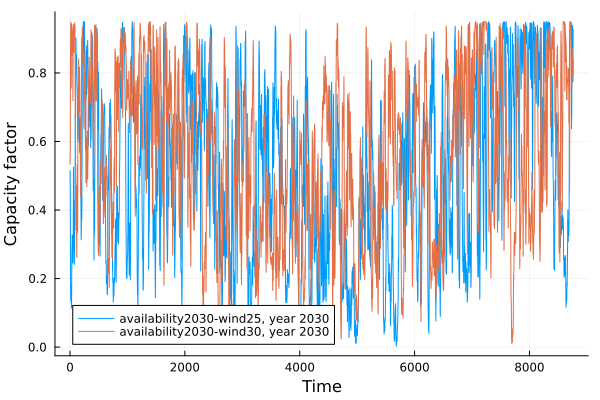

In [47]:
function plot_input_profiles(conn::DuckDB.DB, ::Val{:wind}, year::Int)
    plot()
    profiles = filter(
        row -> occursin(String(:wind), row.profile_name) && row.year == year,
        TIO.get_table(conn, "profiles_rep_periods")
    )

    for pname in unique(profiles.profile_name)
        subdf = profiles[profiles.profile_name .== pname, :]
        plot!(subdf.value, label="$(pname), year $year")
    end
    xlabel!("Time")
    ylabel!("Capacity factor")
end

plot_input_profiles(connection_vintage_standard, Val(:wind), 2030)

In [48]:
@show fieldnames(TEM.EnergyProblem)
# @show dump(TEM.EnergyProblem)
# var_flow = multiyear_vintage_compact.variables[:flow]
# fieldnames(typeof(var_flow))
# typeof(var_flow.indices)
# var_flow.indices.tbl[:id]
multiyear_no_vintage.expressions[:available_asset_units_simple_method]
TIO.show_tables(connection_vintage_compact)


fieldnames(TEM.EnergyProblem) = (:db_connection, :variables, :expressions, :constraints, :profiles, :model_parameters, :model, :solved, :objective_value, :termination_status)


Row,name
,String
1,asset
2,asset_both
3,asset_commission
4,asset_milestone
5,asset_time_resolution_over_clustered_year
6,asset_time_resolution_rep_period
7,assets_profiles
8,assets_rep_periods_partitions
9,assets_timeframe_partitions
